<a href="https://colab.research.google.com/github/mephi82/reinforce/blob/main/grid_world2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import random
from matplotlib import colors

import base64

import IPython
import matplotlib.pyplot as plt
import PIL.Image

import tensorflow as tf
import numpy as np

from tf_agents.environments import py_environment
from tf_agents.environments import tf_environment
from tf_agents.environments import tf_py_environment
from tf_agents.environments import utils
from tf_agents.specs import array_spec
from tf_agents.environments import wrappers
from tf_agents.environments import suite_gym
from tf_agents.trajectories import time_step as ts

from tf_agents.agents.reinforce import reinforce_agent
from tf_agents.drivers import py_driver
from tf_agents.environments import suite_gym
from tf_agents.networks import actor_distribution_network
from tf_agents.policies import py_tf_eager_policy, EpsilonGreedyPolicy
from tf_agents.replay_buffers import reverb_replay_buffer
from tf_agents.replay_buffers import reverb_utils
from tf_agents.specs import tensor_spec
from tf_agents.trajectories import trajectory
from tf_agents.utils import common
n = 4

In [2]:
# pip install --user tf-agents[reverb]

In [42]:
class GridWorld(py_environment.PyEnvironment):
  def __init__(self):
    self._action_spec = array_spec.BoundedArraySpec(
        shape=(), dtype=np.int32, minimum=0, maximum=3, name='action') #left, right
    self._observation_spec = array_spec.BoundedArraySpec(
        shape=(2,), dtype=np.int32, minimum=0, maximum=3, name='observation') 
    self._reset()
    
  def action_spec(self):
    return self._action_spec

  def observation_spec(self):
    return self._observation_spec

  def get_state(self):
    return self._state

  def _reset(self):
    self._state = np.array([3,0], dtype = np.int32)
    return(ts.restart(self._state))

  def transition(self, state, action):
    ri, ci = state
    if action == 0:
      ri = max(ri-1, 0)
    elif action == 1:
      ri = min(ri+1, 3)
    elif action == 2:
      ci = max(ci-1, 0)
    elif action == 3:
      ci = min(ci+1, 3)
    return(np.array([ri,ci], dtype = np.int32))

  def is_terminal(self, state):
    return(all(state == [0,0]) | all(state == [3,3]))

  def _step(self, action):
    # Make sure episodes don't go on forever.
    self._state = self.transition(self._state, action)

    if self.is_terminal(self.state):
      # termination
      return ts.termination(self._state, reward = 0)
    else:
      #continue
      return ts.transition(self._state, reward=-1.0, discount=1.0)
    

env = GridWorld()
env.is_terminal(env._state)

False

In [8]:
utils.validate_py_environment(env, episodes=5)
action = np.array(0, dtype=np.int32)
time_step = env.reset()
print(time_step)
while not time_step.is_last():
  time_step = env.step(action)
  print(time_step)

env.action_spec().num_values

TimeStep(
{'discount': array(1., dtype=float32),
 'observation': array([3, 0], dtype=int32),
 'reward': array(0., dtype=float32),
 'step_type': array(0, dtype=int32)})
TimeStep(
{'discount': array(1., dtype=float32),
 'observation': array([2, 0], dtype=int32),
 'reward': array(-1., dtype=float32),
 'step_type': array(1, dtype=int32)})
TimeStep(
{'discount': array(1., dtype=float32),
 'observation': array([1, 0], dtype=int32),
 'reward': array(-1., dtype=float32),
 'step_type': array(1, dtype=int32)})
TimeStep(
{'discount': array(0., dtype=float32),
 'observation': array([0, 0], dtype=int32),
 'reward': array(0., dtype=float32),
 'step_type': array(2, dtype=int32)})


4

In [50]:
class Policy():
  def __init__(self, observation_spec, action_spec):
    nactions = action_spec.num_values
    dim_obs = observation_spec.num_values

    self.vfun = np.zeros(dim_obs)
    self.pi = np.ones(np.append(dim_obs, nactions))/nactions
    self.qfun = np.zeros(np.append(dim_obs, nactions))

  def evaluate(self):
    for idx, value in np.ndenumerate(self.vfun):
      print(env.is_terminal(np.array(idx)), value)

  def improve(self):
    pass

  def get_value(self, observation):
    return(self.vfun[tuple(observation)])

  def get_probs(self, observation):
    return(self.pi[tuple(observation)])

  def action(self, time_step):
    return(self.get_probs(time_step.observation))
    # return(self.v[tuple(observation)])
  # def ind(self, observation):
  #   return(self.digits.dot(observation))

  # def eval(self, observation):
  #   return(self.v[self.ind(observation)])
  
  # def revalue(self, observation, value):
  #   self.v[self.ind(observation)] = value

  # def improve(self, observation, probs):
  #   self.pi[self.ind(observation)] = probs

optP = Policy(env.observation_spec(), env.action_spec())
optP.get_value(tuple(env._state))
optP.action(time_step)
# env._state.tolist()
# P.v[[0,0]]
# np.take(P.v, env._state)
optP.evaluate()
optP.pi[(0,0)]

# env.is_terminal(np.array([0,0]))


True 0.0
False 0.0
False 0.0
False 0.0
False 0.0
False 0.0
False 0.0
False 0.0
False 0.0
False 0.0
False 0.0
False 0.0
False 0.0
False 0.0
False 0.0
True 0.0


array([0.25, 0.25, 0.25, 0.25])

In [ ]:
class Environment:
    def __init__(self, n, actions, rewards, e_x, e_y):
        self.n = n
        self.actions = actions
        self.rewards = rewards
        self.e_x = e_x
        self.e_y = e_y

def build_grid(n):
    """Build an NxN grid with start and end cells, as well as some barrier cells.
    Args:
        n (int): length and width of the grid
        p_barrier (float): probability of a cell being a barrier
        r_barrier (int): reward for the barrier cells
    Returns:
        env (Environment): grid world environment
    """

    # Define set of possible actions: go left (0), up (1), right (2) or down (4)
    actions = [0, 1, 2, 3]

    # Define start and end cells -> these will have value 0
    e_x = random.randrange(n)
    e_y = random.randrange(n)

    # Define barrier cells -> these will have barrier reward. All other have -1 reward
    rewards = (-1) * np.ones((n, n))

    # Create environment
    env = Environment(n, actions, rewards, e_x, e_y)

    return env



def plot_grid(env):
    """Plot grid
    Args:
        env (Environment): grid world environment
    """

    data = env.rewards.copy()
    data[env.e_x, env.e_y] = 10

    # create discrete colormap
    cmap = colors.ListedColormap(['grey', 'white', 'red'])
    bounds = [-11, -2, 0, 12]
    norm = colors.BoundaryNorm(bounds, cmap.N)

    fig, ax = plt.subplots()
    ax.imshow(data, cmap=cmap, norm=norm)

    # draw gridlines
    ax.grid(which='major', axis='both', linestyle='-', color='k', linewidth=2)
    ax.set_xticks(np.arange(-.5, env.n, 1))
    ax.set_yticks(np.arange(-.5, env.n, 1))

    plt.show()

def plot_v_values(v, n):
    """Plots the value function in each state as a grid.
    Args:
        v (array): numpy array representing the value function
        n (int):
    """

    fig, ax = plt.subplots()
    im = ax.imshow(v, cmap='YlOrBr', interpolation='nearest')

    # draw gridlines
    ax.grid(which='major', axis='both', linestyle='-', color='k', linewidth=2)
    ax.set_xticks(np.arange(-.5, n, 1))
    ax.set_yticks(np.arange(-.5, n, 1))

    # Loop over data dimensions and create text annotations.
    for i in range(n):
        for j in range(n):
            text = ax.text(j, i, "{:.2f}".format(v[i, j]), ha="center", va="center", color="black")

    ax.set_title("Value function")
    fig.tight_layout()
    plt.show() 

def get_arrow(prob_arr):
    """Returns the arrows that represent the highest probability actions.
    Args:
        prob_arr (array): numpy array denoting the probability of taking each action on a given state
    Returns:
        arrow (str): string denoting the most probable action(s)
    """

    best_actions = np.where(prob_arr == np.amax(prob_arr))[0]
    if len(best_actions) == 1:
        if 0 in best_actions:
            return r"$\leftarrow$"
        if 1 in best_actions:
            return r"$\uparrow$"
        if 2 in best_actions:
            return r"$\rightarrow$"
        else:
            return r"$\downarrow$"

    elif len(best_actions) == 2:
        if 0 in best_actions and 1 in best_actions:
            return r"$\leftarrow \uparrow$"
        elif 0 in best_actions and 2 in best_actions:
            return r"$\leftrightarrow$"
        elif 0 in best_actions and 3 in best_actions:
            return r"$\leftarrow \downarrow$"
        elif 1 in best_actions and 2 in best_actions:
            return r"$\uparrow \rightarrow$"
        elif 1 in best_actions and 3 in best_actions:
            return r"$\updownarrow$"
        elif 2 in best_actions and 3 in best_actions:
            return r"$\downarrow \rightarrow$"

    elif len(best_actions) == 3:
        if 0 not in best_actions:
            return r"$\updownarrow \rightarrow$"
        elif 1 not in best_actions:
            return r"$\leftrightarrow \downarrow$"
        elif 2 not in best_actions:
            return r"$\leftarrow \updownarrow$"
        else:
            return r"$\leftrightarrow \uparrow$"

    else:
        return r"$\leftrightarrow \updownarrow$"


def plot_optimal_actions(env, pi):
    """Plots the optimal action to take in each state
    Args:
        env (Environment): grid world environment
        pi (array): numpy array indicating the probability of taking each action in each state
    """

    data = env.rewards.copy()
    data[env.e_x, env.e_y] = 10

    # create discrete colormap
    cmap = colors.ListedColormap(['grey', 'white', 'red'])
    bounds = [-11, -2, 0, 12]
    norm = colors.BoundaryNorm(bounds, cmap.N)

    fig, ax = plt.subplots()
    ax.imshow(data, cmap=cmap, norm=norm)

    # draw gridlines
    ax.grid(which='major', axis='both', linestyle='-', color='k', linewidth=2)
    ax.set_xticks(np.arange(-.5, env.n, 1))
    ax.set_yticks(np.arange(-.5, env.n, 1))

    # Loop over data dimensions and create text annotations.
    for i in range(env.n):
        for j in range(env.n):
            arrow = get_arrow(pi[i, j, :])
            text = ax.text(j, i, arrow, fontsize=16, ha="center", va="center", color="black")

    ax.set_title("Policy")
    fig.tight_layout()
    plt.show()   

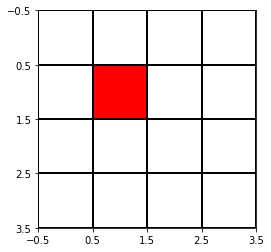

In [ ]:
def get_init_v(env, v0):
    """Defines initial value function v_0
    Args:
        n (int): length and width of the grid
        v0 (float): initial value for the value function (equal for every state)
        e_x (int): x value of the end cell
        e_y (int): y value of the end cell
    Returns:
        v0 (array): initial value function
    """
    n = env.n
    v0 = v0 * np.ones((n, n))

    # Value function of terminal state must be 0
    v0[env.e_x, env.e_y] = 0

    return v0

def get_equiprobable_policy(n):
    """Defines the equiprobable policy. Policy is a matrix s.t.
        pi[x, y, a] = Pr[A = a | S = (x,y)]
    Actions are:
        * 0: go left
        * 1: go up
        * 2: go right
        * 3: go down
    Args:
        n (int): length and width of the grid
    Returns:
        pi (array): numpy array representing the equiprobably policy
    """

    pi = 1/4 * np.ones((n, n, 4))
    return pi
    
def get_next_state(x, y, a, n):
    """Computes next state from current state and action.
    Args:
        x (int): x value of the current state
        y (int): y value of the current state
        a (int): action
        n (int): length and width of the grid
    Returns:
        s_prime_x (int): x value of the next state
        s_prime_y (int): y value of the next state
    """

    # Compute next state according to the action
    if a == 0:
        s_prime_x = x
        s_prime_y = max(0, y - 1)
    elif a == 1:
        s_prime_x = max(0, x - 1)
        s_prime_y = y
    elif a == 2:
        s_prime_x = x
        s_prime_y = min(n - 1, y + 1)
    else:
        s_prime_x = min(n - 1, x + 1)
        s_prime_y = y

    return s_prime_x, s_prime_y
env = build_grid(n)
i = 0
plot_grid(env)

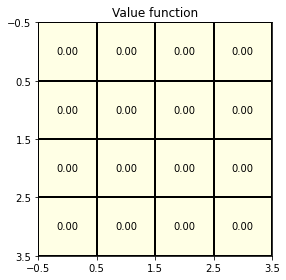

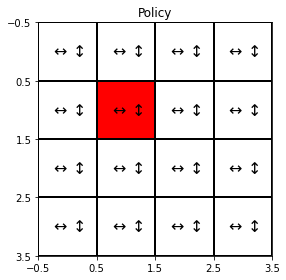

In [ ]:


# Generate initial value function and policy
v = get_init_v(env, 0)
pi = get_equiprobable_policy(env.n)

# Plot initial value function and policy
plot_v_values(v, env.n)
plot_optimal_actions(env, pi)

# policy_stable = False
# while not policy_stable:
#     i += 1
#     print("\nIteration {} of Policy Iteration algorithm".format(i))
#     # Run the policy evaluation
#     policy_evaluation(env, v, pi, gamma, theta)
#     # Run the policy improvement algorithm
#     policy_stable = policy_improvement(env, v, pi, gamma)
#     plot_optimal_actions(env, pi)

# print("\nPolicy Iteration algorithm converged after {} steps".format(i))

1


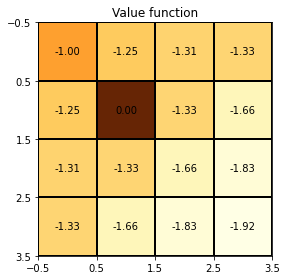

2


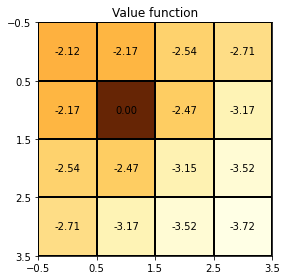

3


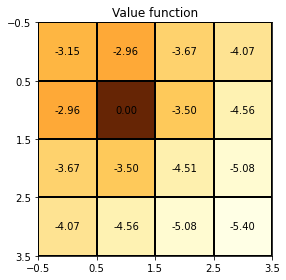

4


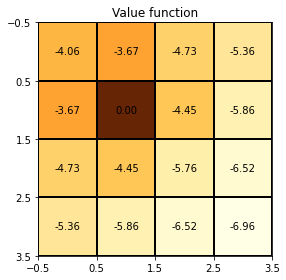

5


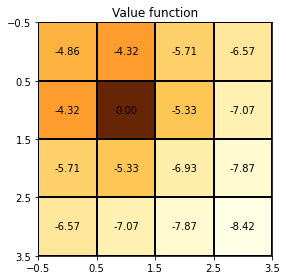

6


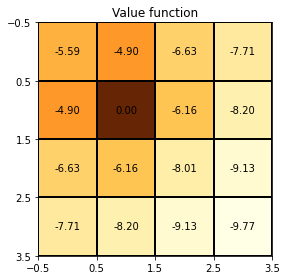

7


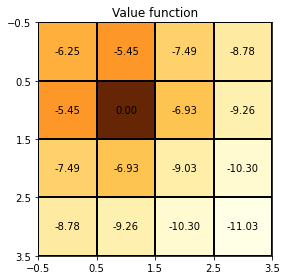

8


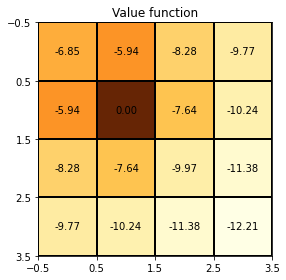

9


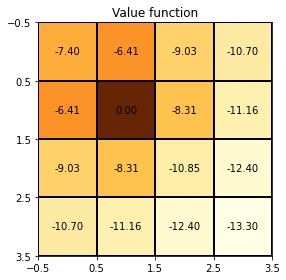

10


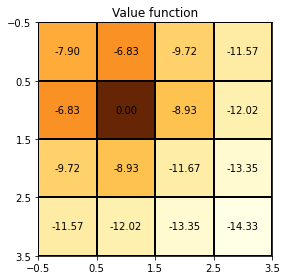

11


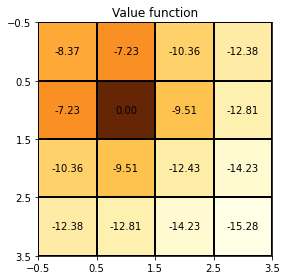

12


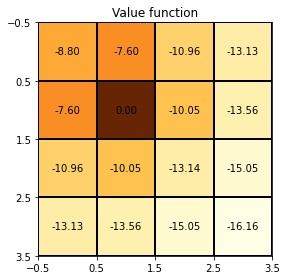

13


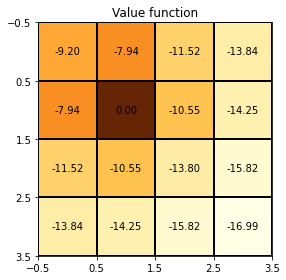

14


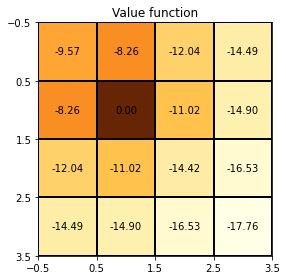

15


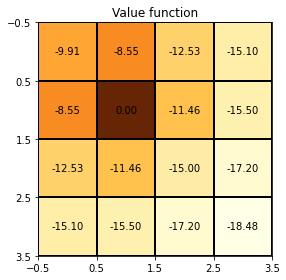

16


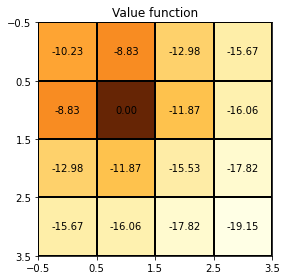

17


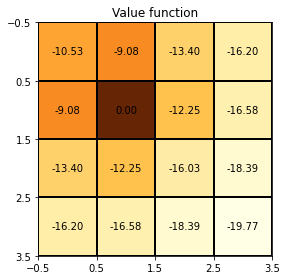

18


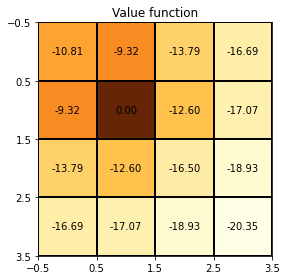

19


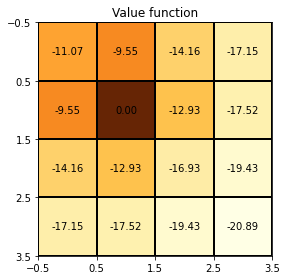

20


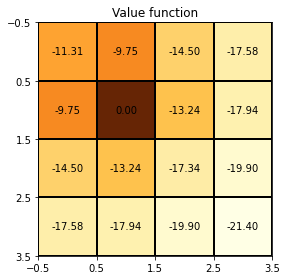

21


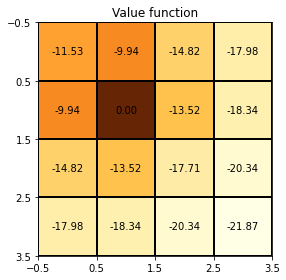

22


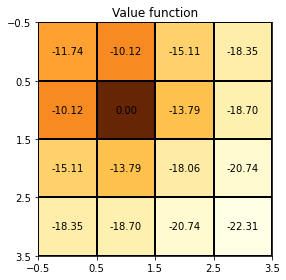

23


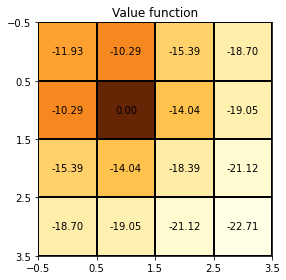

24


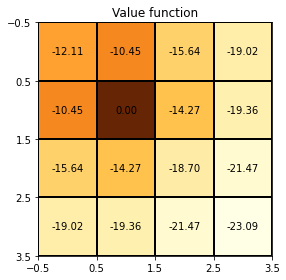

25


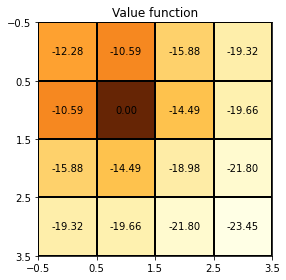

26


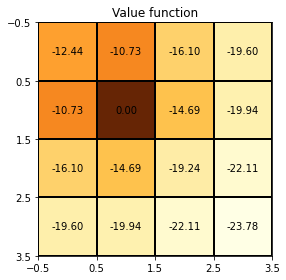

27


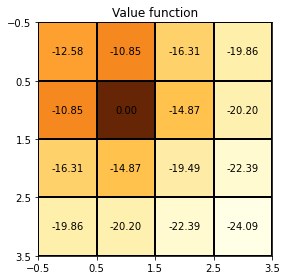

28


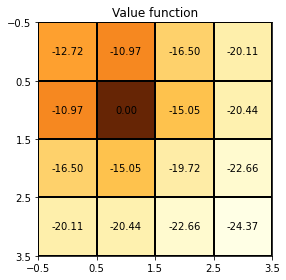

29


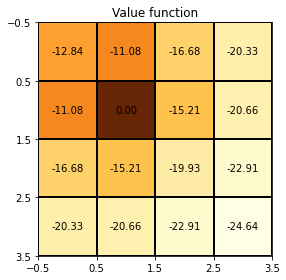

30


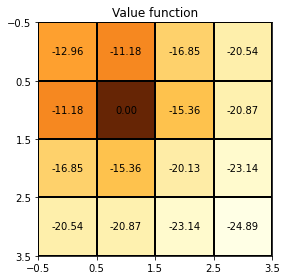

31


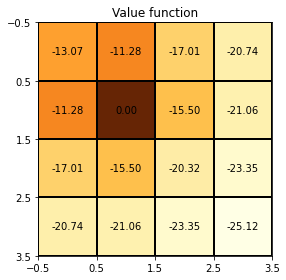

32


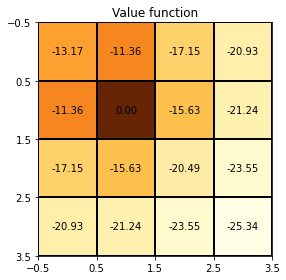

33


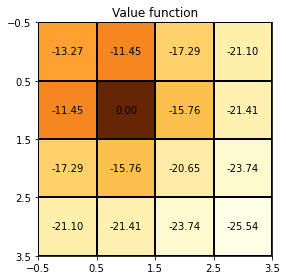

34


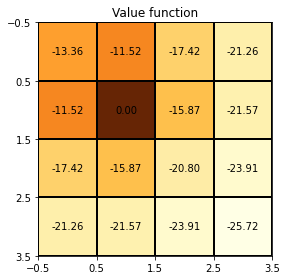

35


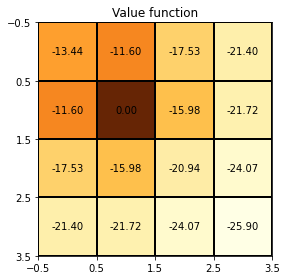

36


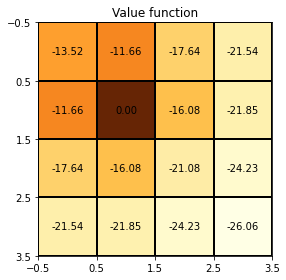

37


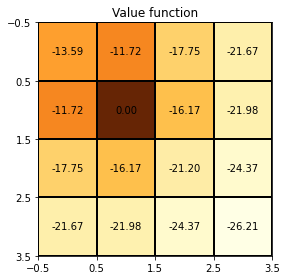

38


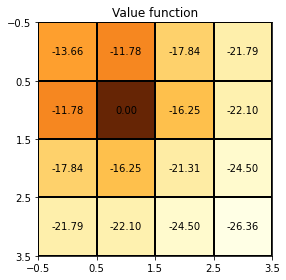

39


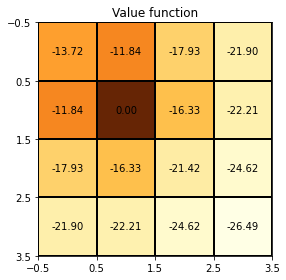

40


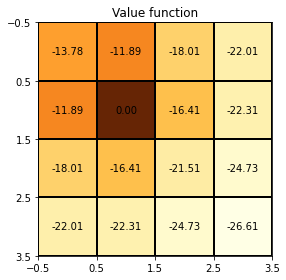

41


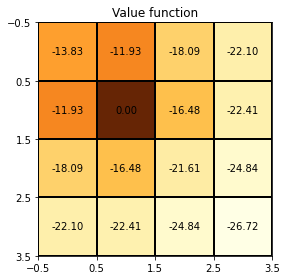

42


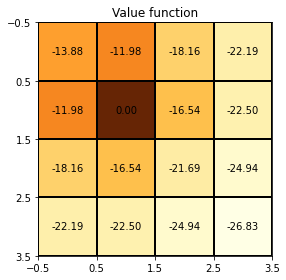

43


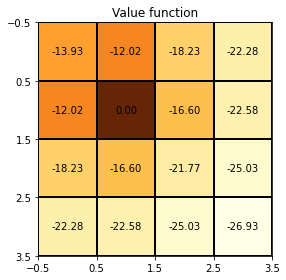

44


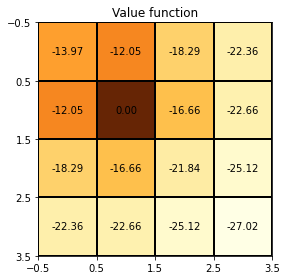

45


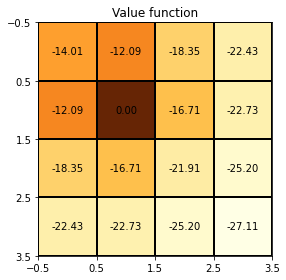

46


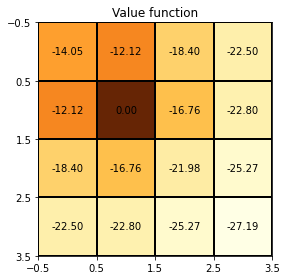

47


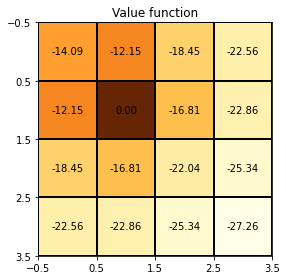

48


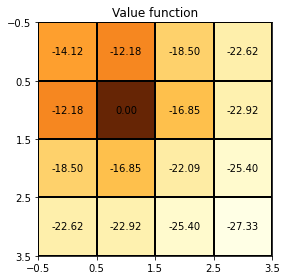

49


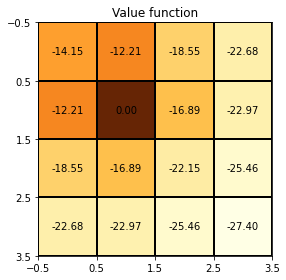

50


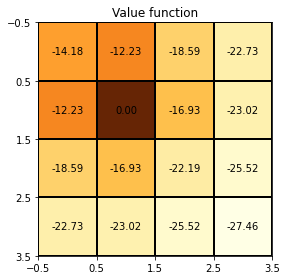

51


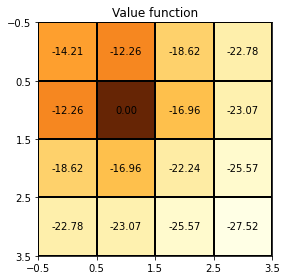

52


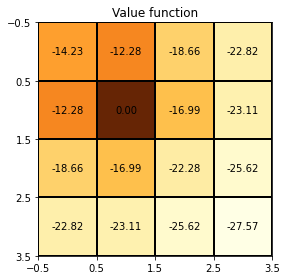

53


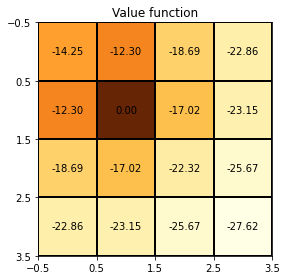

54


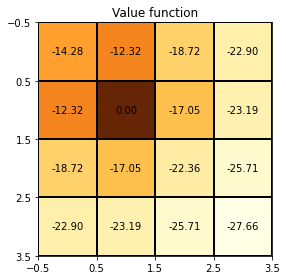

55


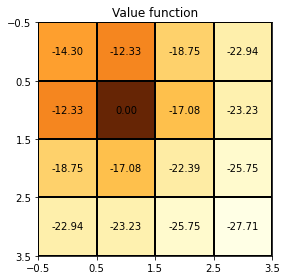

56


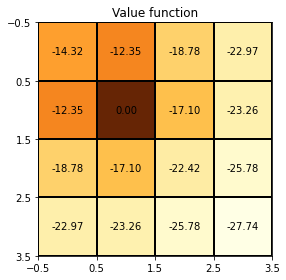

57


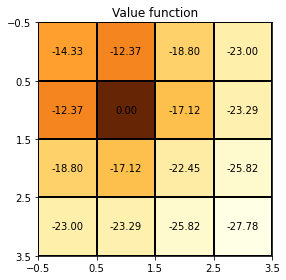

58


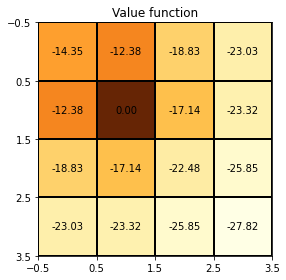

59


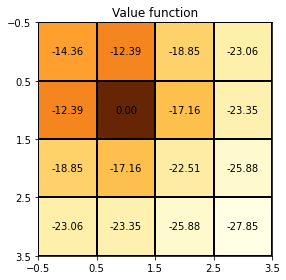

60


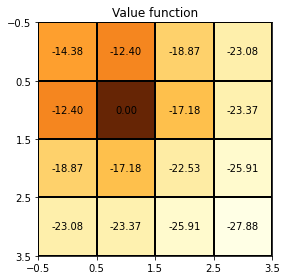

61


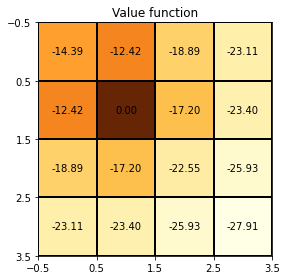

62


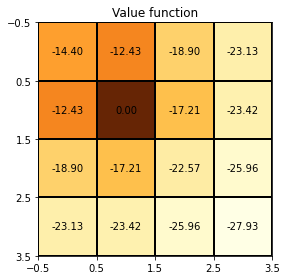

63


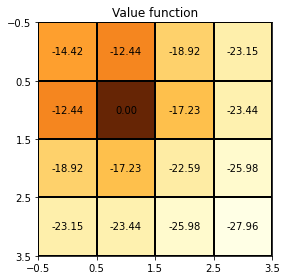

64


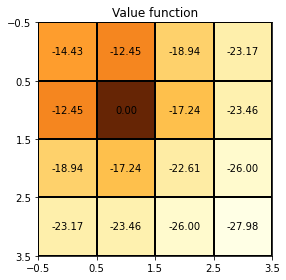

65


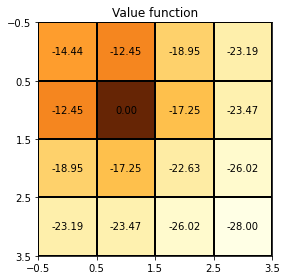

66


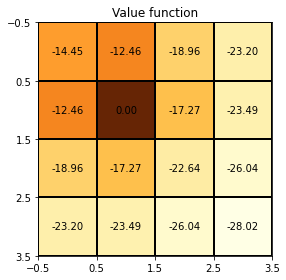

67


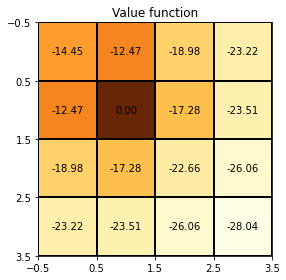

68


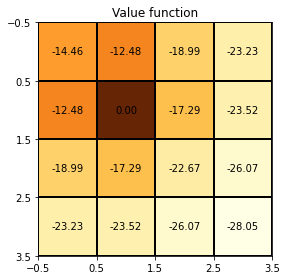

69


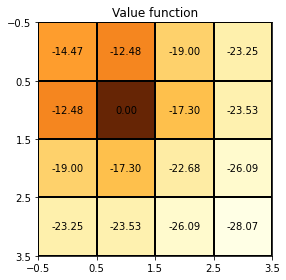

70


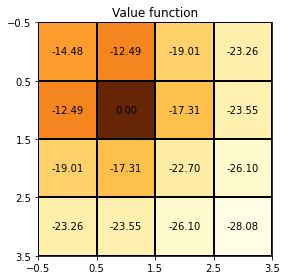

71


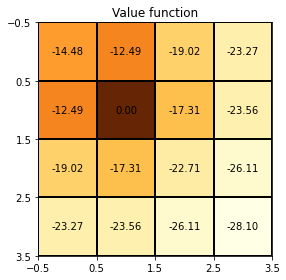

72


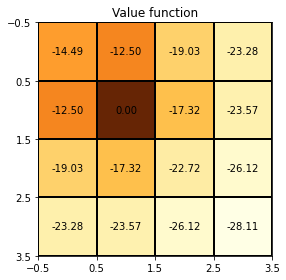

73


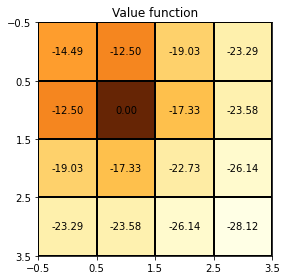

74


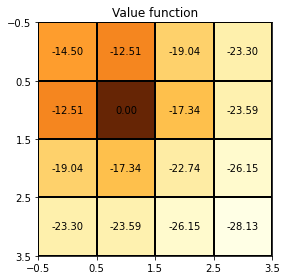

75


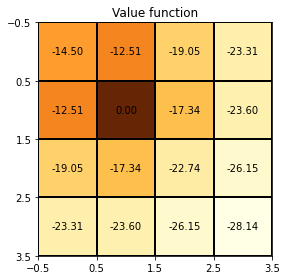

76


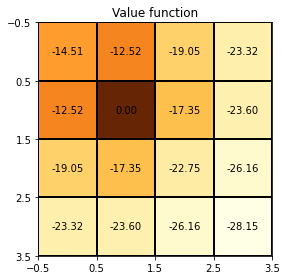

In [ ]:
# v, pi
theta = 0.01
gamma = 1

v = get_init_v(env, 0)
pi = get_equiprobable_policy(env.n)

delta = theta + 1
iter = 0
while delta >= theta: #and iter <10:
  oldv = v.copy()
  delta = 0
  for x in range(env.n):
    for y in range(env.n):
      if x == env.e_x and y == env.e_y:
        continue

      temp_v = 0
      for a in env.actions:
        s_prime_x, s_prime_y = get_next_state(x, y, a, env.n)
        temp_v += pi[x,y,a] * (env.rewards[s_prime_x,s_prime_y] + gamma * v[s_prime_x, s_prime_y])
      v[x,y] = temp_v
      delta = max(delta, np.abs(oldv[x,y] - v[x,y]))
      
  iter += 1
  print(iter)
  plot_v_values(v, env.n)